In [1]:
import warnings
import pandas as pd
import torch
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv("CryptoLin_IE_v2.csv")
c = df['final_manual_labelling'].value_counts()
p = df['final_manual_labelling'].value_counts(normalize=True)
pd.concat([c,p], axis=1, keys=['counts', '%'])

,counts,%
final_manual_labelling,,
1,1366,0.509132
0,921,0.343272
-1,396,0.147596


In [3]:
df.drop(['id'],inplace=True,axis=1)
input_df = df[['date','news','final_manual_labelling']]
input_df.head(6)

,date,news,final_manual_labelling
0,2022-01-25,"Ripple announces stock buyback, nabs $15 billi...",1
1,2022-01-25,IMF directors urge El Salvador to remove Bitco...,-1
2,2022-01-25,Dragonfly Capital is raising $500 million for ...,1
3,2022-01-25,Rick and Morty co-creator collaborates with Pa...,0
4,2022-01-25,How fintech SPACs lost their shine,0
5,2022-01-25,Multichain vulnerability put a billion dollars...,-1


### The Original FinBERT model

In [4]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [5]:
print(torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

False


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
def apply_finbert(x):
    inputs = tokenizer([x], padding = True, truncation = True, return_tensors='pt').to(device)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1) 
    return predictions[:, 0].tolist()[0], predictions[:, 1].tolist()[0], predictions[:, 2].tolist()[0]

In [7]:
input_df[['Positive','Negative','Neutral']] = (input_df['news'].apply(apply_finbert)).apply(pd.Series)
input_df

,date,news,final_manual_labelling,Positive,Negative,Neutral
0,2022-01-25,"Ripple announces stock buyback, nabs $15 billi...",1,0.098288,0.020569,0.881142
1,2022-01-25,IMF directors urge El Salvador to remove Bitco...,-1,0.047823,0.162971,0.789207
2,2022-01-25,Dragonfly Capital is raising $500 million for ...,1,0.156997,0.008097,0.834906
3,2022-01-25,Rick and Morty co-creator collaborates with Pa...,0,0.055608,0.015489,0.928903
4,2022-01-25,How fintech SPACs lost their shine,0,0.039964,0.472788,0.487248
...,...,...,...,...,...,...
2678,2020-05-01,Gambling for a good cause  CryptoSlots donate...,1,0.178831,0.008580,0.812589
2679,2020-04-18,"Litecoin, The Chinese Alternative to Bitcoin",0,0.105272,0.009314,0.885414
2680,2020-04-10,Do You Know What is Happening to Money?,0,0.027453,0.304318,0.668229
2681,2018-07-30,Download CoinMarketCal app on App Store,0,0.046135,0.015244,0.938621


In [8]:
def calculate_result(df):
    df['result'] = df[['Positive', 'Negative', 'Neutral']].idxmax(axis=1).map({
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    })
    return df

In [9]:
original_df = calculate_result(input_df)
original_df

,date,news,final_manual_labelling,Positive,Negative,Neutral,result
0,2022-01-25,"Ripple announces stock buyback, nabs $15 billi...",1,0.098288,0.020569,0.881142,0
1,2022-01-25,IMF directors urge El Salvador to remove Bitco...,-1,0.047823,0.162971,0.789207,0
2,2022-01-25,Dragonfly Capital is raising $500 million for ...,1,0.156997,0.008097,0.834906,0
3,2022-01-25,Rick and Morty co-creator collaborates with Pa...,0,0.055608,0.015489,0.928903,0
4,2022-01-25,How fintech SPACs lost their shine,0,0.039964,0.472788,0.487248,0
...,...,...,...,...,...,...,...
2678,2020-05-01,Gambling for a good cause  CryptoSlots donate...,1,0.178831,0.008580,0.812589,0
2679,2020-04-18,"Litecoin, The Chinese Alternative to Bitcoin",0,0.105272,0.009314,0.885414,0
2680,2020-04-10,Do You Know What is Happening to Money?,0,0.027453,0.304318,0.668229,0
2681,2018-07-30,Download CoinMarketCal app on App Store,0,0.046135,0.015244,0.938621,0


In [10]:

y_true = original_df['final_manual_labelling']
y_pred = original_df['result']


CryptoLin_acc = accuracy_score(y_true, y_pred)
CryptoLin_recall = recall_score(y_true, y_pred, average='macro')
CryptoLin_precision = precision_score(y_true, y_pred, average='macro')
CryptoLin_f1 = f1_score(y_true, y_pred, average='macro')
CryptoLin_cm = confusion_matrix(y_true, y_pred, labels=[1, 0, -1])

print(f"Accuracy: {CryptoLin_acc:.3f}")
print(f"Precision: {CryptoLin_precision:.3f}")
print(f"Recall: {CryptoLin_recall:.3f}")
print(f"F1 Score: {CryptoLin_f1:.3f}")
print("Confusion Matrix:\n", CryptoLin_cm)

Accuracy: 0.514
Precision (macro): 0.622
Recall (macro): 0.548
F1 Score (macro): 0.524
Confusion Matrix:
 [[424 910  32]
 [ 97 751  73]
 [ 12 179 205]]


### The original FinBERT has 51.4% accuaracy on CryptoLin dataset

In [11]:
label_df = pd.read_csv('finbert_600.csv')
label_df = label_df[['title','ground_truth']]
label_df

,title,ground_truth
0,Nigella Lawson reveals her favourite Australia...,0
1,"In nostalgia trip , Tata Sky Seniors brings ba...",0
2,Buying Myself Back : Emily Ratajkowski is mint...,1
3,Thousands of Johnson & Johnson COVID - 19 vacc...,0
4,Hillicon Valley : Huawei to move toward softwa...,-1
...,...,...
595,Markets in first - quarter : Riding a tiger an...,0
596,Business Highlights,0
597,Markets in first quarter : Riding a tiger and ...,0
598,Markets in first - quarter : Riding a tiger an...,0


In [12]:
label_df[['Positive','Negative','Neutral']] = (label_df['title'].apply(apply_finbert)).apply(pd.Series)
label_df

,title,ground_truth,Positive,Negative,Neutral
0,Nigella Lawson reveals her favourite Australia...,0,0.059604,0.025841,0.914555
1,"In nostalgia trip , Tata Sky Seniors brings ba...",0,0.166865,0.019249,0.813886
2,Buying Myself Back : Emily Ratajkowski is mint...,1,0.086113,0.016892,0.896995
3,Thousands of Johnson & Johnson COVID - 19 vacc...,0,0.180287,0.012893,0.806820
4,Hillicon Valley : Huawei to move toward softwa...,-1,0.128783,0.667682,0.203536
...,...,...,...,...,...
595,Markets in first - quarter : Riding a tiger an...,0,0.049169,0.039496,0.911336
596,Business Highlights,0,0.036064,0.039853,0.924082
597,Markets in first quarter : Riding a tiger and ...,0,0.106947,0.027508,0.865545
598,Markets in first - quarter : Riding a tiger an...,0,0.080970,0.029285,0.889745


In [13]:
fin_600_df = calculate_result(label_df)
fin_600_df

,title,ground_truth,Positive,Negative,Neutral,result
0,Nigella Lawson reveals her favourite Australia...,0,0.059604,0.025841,0.914555,0
1,"In nostalgia trip , Tata Sky Seniors brings ba...",0,0.166865,0.019249,0.813886,0
2,Buying Myself Back : Emily Ratajkowski is mint...,1,0.086113,0.016892,0.896995,0
3,Thousands of Johnson & Johnson COVID - 19 vacc...,0,0.180287,0.012893,0.806820,0
4,Hillicon Valley : Huawei to move toward softwa...,-1,0.128783,0.667682,0.203536,-1
...,...,...,...,...,...,...
595,Markets in first - quarter : Riding a tiger an...,0,0.049169,0.039496,0.911336,0
596,Business Highlights,0,0.036064,0.039853,0.924082,0
597,Markets in first quarter : Riding a tiger and ...,0,0.106947,0.027508,0.865545,0
598,Markets in first - quarter : Riding a tiger an...,0,0.080970,0.029285,0.889745,0


In [14]:
accuracy_score(y_true=fin_600_df['ground_truth'], y_pred=fin_600_df['result'])

0.6483333333333333

In [15]:
y_true = fin_600_df['ground_truth']
y_pred = fin_600_df['result']

GDELT_acc = accuracy_score(y_true, y_pred)
GDELT_recall = recall_score(y_true, y_pred, average='macro')
GDELT_precision = precision_score(y_true, y_pred, average='macro')
GDELT_f1 = f1_score(y_true, y_pred, average='macro')
GDELT_cm = confusion_matrix(y_true, y_pred, labels=[1, 0, -1])

print(f"Accuracy: {GDELT_acc:.3f}")
print(f"Precision: {GDELT_precision:.3f}")
print(f"Recall: {GDELT_recall:.3f}")
print(f"F1 Score: {GDELT_f1:.3f}")
print("Confusion Matrix:\n", GDELT_cm)

Accuracy: 0.648
Precision (macro): 0.727
Recall (macro): 0.616
F1 Score (macro): 0.618
Confusion Matrix:
 [[ 64 144   6]
 [ 13 264  14]
 [  0  34  61]]


## The original FinBERT has 64.8% accuracy on fin_600

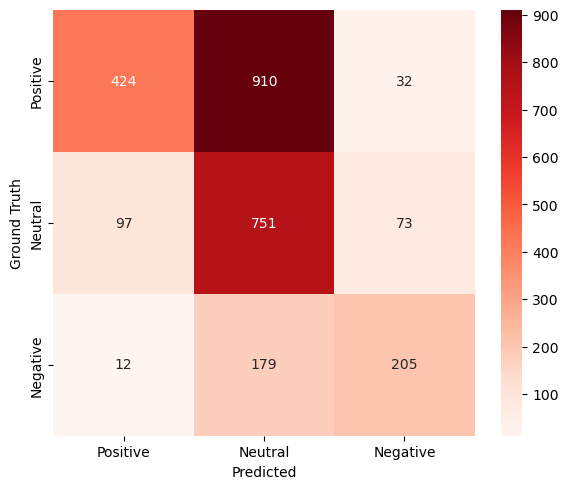

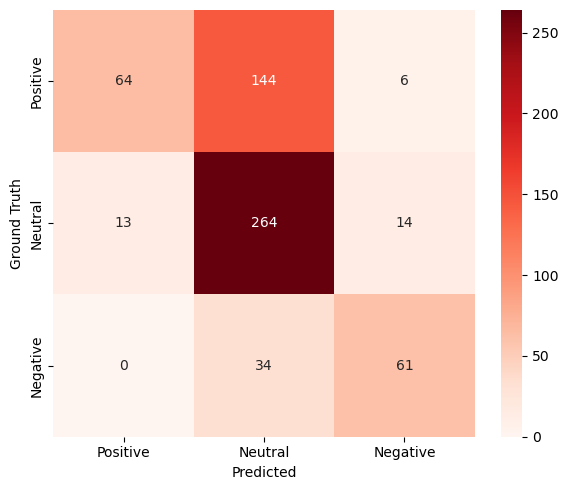

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = ['Positive',  'Neutral', 'Negative']

def plot_confusion_matrix(matrix, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Reds',
                xticklabels=labels, yticklabels=labels)
    #plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(CryptoLin_cm, "CryptoLin")
plot_confusion_matrix(GDELT_cm, "GDELT Subset")


In [17]:
CryptoLin_acc

0.5143496086470369

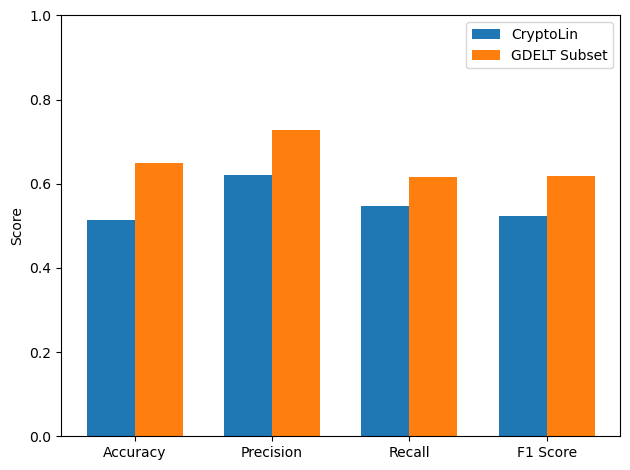

In [20]:
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
cryptolin_scores = CryptoLin_acc, CryptoLin_precision, CryptoLin_recall, CryptoLin_f1
gdelt_scores = GDELT_acc, GDELT_precision, GDELT_recall, GDELT_f1

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, cryptolin_scores, width, label='CryptoLin')
bar2 = ax.bar(x + width/2, gdelt_scores, width, label='GDELT Subset')

ax.set_ylabel('Score')
#ax.set_title('FinBERT Performance on CryptoLin dataset and GDELT subset')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
